# Gaussian on a Grid Test for Hierarchical ABI with compositional score matching

In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from bayesflow import diagnostics
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

/Users/jonas.arruda/miniconda/envs/hierarchical-abi/lib/python3.12/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
torch_device = torch.device("cpu")

In [3]:
class Simulator:
    def __init__(self, n_grid=8):
        self.n_grid = n_grid
        self.max_time = 100
        self.n_time_points = 10  # number of observation points to return
        self.dt = 0.1            # simulation time step
        self.n_time_steps = int(self.max_time / self.dt)  # number of simulation steps

    def __call__(self, params):
        """
        Simulate Brownian motion with drift.

        The SDE is:
            dx(t) = mu * dt + tau * sqrt(dt) * dW(t)
        starting from 0.

        The simulation runs for self.n_time_steps steps (with step dt)
        and then returns self.n_time_points evenly spaced observations
        between 0 and self.max_time.

        The parameter dict 'params' must contain:
            - 'mu': drift coefficient
            - 'log_tau': log of the diffusion coefficient

        These parameters can be provided as:
            - A scalar (for a single grid element),
            - A 2D array of shape (batch_size, 1) or (batch_size, n_grid)
              for batch simulations over a one-dimensional grid,
            - A 3D array of shape (batch_size, n_grid, n_grid)
              for batch simulations over a two-dimensional grid.
        """
        # Convert parameters to numpy arrays.
        theta = np.array(params['theta'])

        # Determine simulation mode and grid shape.
        if theta.ndim in (0,1):
            # Scalar: simulate a single grid element.
            grid_shape = (1,1)
            theta = np.full(grid_shape, theta)
        elif theta.ndim == 2:
            # 2D array: shape (batch_size, d) where d==1.
            if theta.shape[1] == 1:
                grid_shape = (1,1)
            else:
                raise ValueError("For 2D 'theta', the second dimension must be 1.")
        elif theta.ndim == 3:
            # 3D array: shape (batch_size, n_grid, n_grid)
            if theta.shape[1] != self.n_grid or theta.shape[2] != self.n_grid:
                raise ValueError("For 3D 'theta', the second and third dimensions must equal n_grid.")
            grid_shape = (self.n_grid, self.n_grid)
        else:
            raise ValueError("Parameter 'theta' must be provided as a scalar, 2D array, or 3D array.")
        batch_size = theta.shape[0]

        # Simulate the full trajectory.
        # The noise will have shape: (batch_size, n_time_steps, *grid_shape)
        noise_shape = (batch_size, self.n_time_steps) + grid_shape
        noise = np.random.normal(loc=0, scale=1, size=noise_shape)

        # Expand mu and tau to include a time axis.
        if theta.ndim in (1, 2):
            # mu and tau have shape (batch_size, grid) in the 2D case
            # For a scalar, we already set them to shape (1,)
            # Expand to (batch_size, 1, grid)
            if batch_size == 1:
                # Ensure shape is (1, 1, grid)
                theta_expanded = theta[np.newaxis, np.newaxis, :]
            else:
                theta_expanded = theta[:, np.newaxis, np.newaxis, :]
        else:
            # For 3D parameters, mu and tau have shape (batch_size, n_grid, n_grid)
            # Expand to (batch_size, 1, n_grid, n_grid)
            theta_expanded = theta[:, np.newaxis, :, :]

        # Compute increments:
        #   increment = mu * dt + tau * sqrt(dt) * noise
        increments = theta_expanded * self.dt + 1 * np.sqrt(self.dt) * noise

        # Initial condition: zeros with shape (batch_size, 1, *grid_shape)
        x0 = np.zeros((batch_size, 1) + grid_shape)
        # Full trajectory: shape (batch_size, n_time_steps+1, *grid_shape)
        traj_full = np.concatenate([x0, np.cumsum(increments, axis=1)], axis=1)

        # Sample self.n_time_points evenly spaced indices from the full trajectory.
        # These indices span from 0 to self.n_time_steps.
        indices = np.linspace(self.n_time_points, self.max_time, self.n_time_points, dtype=int)
        traj_sampled = traj_full[:, indices, ...]  # shape: (batch_size, n_time_points, *grid_shape)

        if theta.ndim == 2:  # just one grid element
            traj_sampled = traj_sampled.reshape(batch_size, self.n_time_points, 1)
        return dict(observable=traj_sampled)

class Prior:
    def __init__(self):
        self.mu_mean = 0
        self.mu_std = 3
        self.log_tau_mean = 0
        self.log_tau_std = 1

        np.random.seed(0)
        test_prior = self.sample_single(1000)
        self.simulator = Simulator()
        test = self.simulator(test_prior,)
        self.x_mean = torch.tensor([np.mean(test['observable'])], dtype=torch.float32, device=torch_device)
        self.x_std = torch.tensor([np.std(test['observable'])], dtype=torch.float32, device=torch_device)
        self.prior_global_mean = torch.tensor(np.array([np.mean(test_prior['mu']), np.mean(test_prior['log_tau'])]),
                                              dtype=torch.float32, device=torch_device)
        self.prior_global_std = torch.tensor(np.array([np.std(test_prior['mu']), np.std(test_prior['log_tau'])]),
                                             dtype=torch.float32, device=torch_device)
        self.prior_local_mean = torch.tensor(np.array([np.mean(test_prior['theta'])]),
                                             dtype=torch.float32, device=torch_device)
        self.prior_local_std = torch.tensor(np.array([np.std(test_prior['theta'])]),
                                            dtype=torch.float32, device=torch_device)

    def __call__(self, batch_size):
        return self.sample_single(batch_size)

    def sample_single(self, batch_size):
        mu = np.random.normal(loc=self.mu_mean, scale=self.mu_std, size=(batch_size,1))
        log_tau = np.random.normal(loc=self.log_tau_mean, scale=self.log_tau_std, size=(batch_size,1))
        theta = np.random.normal(loc=mu, scale=np.exp(log_tau), size=(batch_size, 1))
        return dict(mu=mu, log_tau=log_tau, theta=theta)

    def sample_full(self, batch_size):
        mu = np.random.normal(loc=self.mu_mean, scale=self.mu_std, size=(batch_size, 1))
        log_tau = np.random.normal(loc=self.log_tau_mean, scale=self.log_tau_std, size=(batch_size, 1))
        theta = np.random.normal(loc=mu[:, np.newaxis], scale=np.exp(log_tau)[:, np.newaxis],
                                 size=(batch_size, self.simulator.n_grid, self.simulator.n_grid))
        return dict(mu=mu, log_tau=log_tau, theta=theta)

    def score_global_batch(self, theta_batch_norm, condition_norm=None):
        """ Computes the global score for a batch of parameters."""
        theta_batch = theta_batch_norm * self.prior_global_std + self.prior_global_mean
        mu, log_tau = theta_batch[..., 0], theta_batch[..., 1]
        grad_logp_mu = -(mu - self.mu_mean) / (self.mu_std**2)
        grad_logp_tau = -(log_tau - self.log_tau_mean) / (self.log_tau_std**2)
        # correct the score for the normalization
        score = torch.stack([grad_logp_mu, grad_logp_tau], dim=-1)
        return score / self.prior_global_std

    def score_local_batch(self, theta_batch_norm, condition_norm):
        """ Computes the local score for a batch of samples. """
        theta = theta_batch_norm * self.prior_local_std + self.prior_local_mean
        condition = condition_norm * self.prior_global_std + self.prior_global_mean
        mu, log_tau = condition[..., 0], condition[..., 1]
        # Gradient w.r.t theta conditioned on mu and log_tau
        grad_logp_theta = -(theta - mu) / torch.exp(log_tau*2)
        # correct the score for the normalization
        score = grad_logp_theta / self.prior_local_std
        return score

prior = Prior()
n_params_global = 2
n_params_local = 1

In [4]:
prior(2)

{'mu': array([[-2.489162  ],
        [ 0.63032328]]),
 'log_tau': array([[ 0.57950858],
        [-0.59442986]]),
 'theta': array([[-5.79345437],
        [ 0.59680571]])}

In [5]:
def generate_synthetic_data(n_samples, n_grid=8, full_grid=False, device=None):
    if full_grid:
        batch_params = prior.sample_full(n_samples)
    else:
        batch_params = prior.sample_single(n_samples)
    simulator = Simulator(n_grid=n_grid)
    sim_batch = simulator(batch_params)

    param_global = torch.tensor(np.concatenate([batch_params['mu'], batch_params['log_tau']], axis=1),
                                dtype=torch.float32, device=device)
    param_local = torch.tensor(batch_params['theta'], dtype=torch.float32, device=device)
    data = torch.tensor(sim_batch['observable'], dtype=torch.float32, device=device)
    return param_global, param_local, data

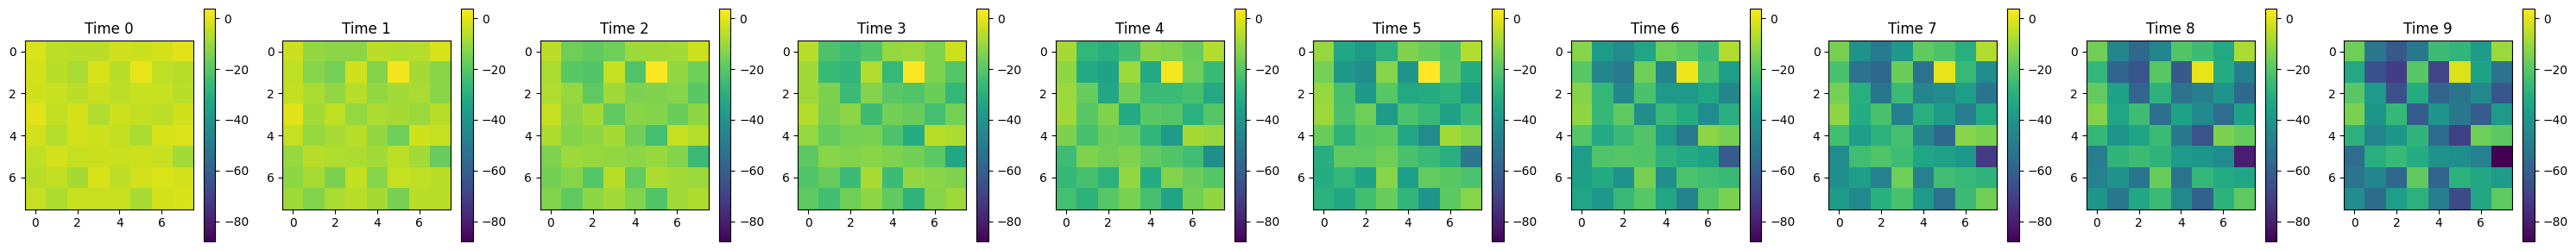

In [6]:
def visualize_simulation_output(sim_output, title_prefix="Time", cmap="viridis", same_scale=True):
    """
    Visualize the full simulation trajectory on a grid of subplots.

    Parameters:
        sim_output (np.ndarray): Simulation trajectory output.
            For a single simulation, it can be either:
              - 2D: shape (n_time_points, grid_size) for a 1D grid, or
              - 3D: shape (n_time_points, n_grid, n_grid) for a 2D grid.
            For batched simulations, the shape is:
              - 3D: (batch_size, n_time_points, grid_size) or
              - 4D: (batch_size, n_time_points, n_grid, n_grid).
            In such cases, only the first simulation (i.e. first batch element) is visualized.
        title_prefix (str, list): Prefix for subplot titles.
        cmap (str): Colormap for imshow when visualizing 2D grid outputs.
    """
    # If a batch dimension is present, select the first simulation.
    if sim_output.ndim == 4:
        # (batch_size, n_time_points, n_grid, n_grid)
        sim_output = sim_output[0]

    # Determine number of time points.
    n_time_points = sim_output.shape[0]

    # Automatically choose grid layout (approximate square).
    n_cols = n_time_points
    n_rows = 1

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))
    # Flatten axes array in case it's 2D.
    axes = np.array(axes).reshape(-1)

    for i in range(n_time_points):
        ax = axes[i]
        # Check if the grid is 1D or 2D.
        # 2D grid: shape (n_time_points, n_grid, n_grid)
        if same_scale:
            im = ax.imshow(sim_output[i], cmap=cmap, vmin=sim_output.min(), vmax=sim_output.max())
        else:
            im = ax.imshow(sim_output[i], cmap=cmap)
        if isinstance(title_prefix, list):
            ax.set_title(title_prefix[i])
        else:
            ax.set_title(f"{title_prefix} {i}")
        fig.colorbar(im, ax=ax)

    # Hide any unused subplots.
    for j in range(n_time_points, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
    return

test = prior.sample_full(1)
simulator_test = Simulator()
sim_test = simulator_test(test)['observable']
visualize_simulation_output(sim_test)

In [7]:
def positional_encoding(t, d_model, max_t=1000.0):
    """
    Computes the sinusoidal positional encoding for a given time t.

    Args:
        t (torch.Tensor): The input time tensor of shape (batch_size, 1).
        d_model (int): The dimensionality of the embedding.

    Returns:
        torch.Tensor: The positional encoding of shape (batch_size, d_model).
    """
    half_dim = d_model // 2
    div_term = torch.exp(torch.arange(half_dim, dtype=torch.float32, device=t.device) *
                         -(math.log(max_t) / (half_dim - 1)))
    t_proj = t * div_term
    pos_enc = torch.cat([torch.sin(t_proj), torch.cos(t_proj)], dim=-1)
    return pos_enc

# Define the Score Model
class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout_rate=0.1):
        super(ResidualBlock, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.norm = nn.LayerNorm(out_features)
        self.activation = nn.SiLU()  # same as swish
        self.dropout = nn.Dropout(dropout_rate)
        self.proj = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()

    @staticmethod
    def swish(x):
        return x * torch.sigmoid(x)

    def forward(self, x):
        identity = self.proj(x)
        out = self.linear(x)
        out = self.norm(out)
        out = self.activation(out)
        out = self.dropout(out)
        return out + identity

class ConditionalResidualBlock(nn.Module):
    def __init__(self, hidden_dim, cond_dim, dropout=0.1):
        super(ConditionalResidualBlock, self).__init__()
        # First linear layer that takes [hidden state; conditioning]
        self.fc1 = nn.Linear(hidden_dim + cond_dim, hidden_dim)
        self.norm1 = nn.LayerNorm(hidden_dim)
        # Second linear layer also takes [hidden state; conditioning]
        self.fc2 = nn.Linear(hidden_dim + cond_dim, hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.activation = nn.SiLU()  # same as swish
        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def swish(x):
        return x * torch.sigmoid(x)

    def forward(self, h, cond):
        # Concatenate the hidden state with the conditioning vector
        x = torch.cat([h, cond], dim=-1)
        out = self.fc1(x)
        out = self.norm1(out)
        out = self.activation(out)
        out = self.dropout(out)
        # Inject conditioning again before the second transformation
        out = self.fc2(torch.cat([out, cond], dim=-1))
        out = self.norm2(out)
        # Add the original hidden state (skip connection) and apply activation
        return self.activation(out + h)

class ScoreModel(nn.Module):
    """
        Neural network model that computes score estimates.

        Args:
            input_dim_theta (int): Input dimension for theta.
            input_dim_x (int): Input dimension for x.
            input_dim_condition (int): Input dimension for the condition. Can be 0 for global score.
            hidden_dim (int): Hidden dimension for theta network.
            time_embed_dim (int, optional): Dimension of time embedding. Defaults to 4.
    """
    def __init__(self,
                 input_dim_theta, input_dim_x, input_dim_condition,
                 hidden_dim,
                 time_embed_dim=16):
        super(ScoreModel, self).__init__()
        self.time_embed_dim = time_embed_dim

        # Define the dimension of the conditioning vector
        cond_dim = input_dim_x + input_dim_condition + time_embed_dim
        self.cond_dim = cond_dim

        # Project the concatenation of theta and the condition into hidden_dim
        self.input_layer = nn.Linear(input_dim_theta + cond_dim, hidden_dim)

        # Create a sequence of conditional residual blocks
        self.block1 = ConditionalResidualBlock(hidden_dim, cond_dim)
        self.block2 = ConditionalResidualBlock(hidden_dim, cond_dim)
        self.block3 = ConditionalResidualBlock(hidden_dim, cond_dim)

        # Create a sequence of residual blocks
        #self.block1 = ResidualBlock(input_dim_theta + cond_dim, hidden_dim)
        #self.block2 = ResidualBlock(hidden_dim, hidden_dim)
        #self.block3 = ResidualBlock(hidden_dim, hidden_dim)

        # Final layer to get back to the theta dimension
        self.final_linear = nn.Linear(hidden_dim, input_dim_theta)

    def forward(self, theta, t, x, conditions=None):
        """
        Forward pass of the ScoreModel.

        Args:
            theta (torch.Tensor): Input theta tensor of shape (batch_size, input_dim_theta).
            t (torch.Tensor): Input time tensor of shape (batch_size, 1).
            x (torch.Tensor): Input x tensor of shape (batch_size, input_dim_x).
            conditions (torch.Tensor, optional): Input condition tensor of shape (batch_size, input_dim_condition).
                Defaults to None.

        Returns:
            torch.Tensor: Output of the score model.
        """
        # Compute a time embedding (shape: [batch, time_embed_dim])
        t_emb = positional_encoding(t, self.time_embed_dim)

        # Form the conditioning vector. If conditions is None, only x and time are used.
        if conditions is not None:
            cond = torch.cat([x, conditions, t_emb], dim=-1)
        else:
            cond = torch.cat([x, t_emb], dim=-1)

        # Concatenate theta with the conditioning vector as the initial input
        h = torch.cat([theta, cond], dim=-1)
        h = self.input_layer(h)

        # Pass through each residual block, injecting the same cond at each layer
        h = self.block1(h, cond)
        h = self.block2(h, cond)
        h = self.block3(h, cond)

        theta_emb = self.final_linear(h)
        return theta_emb


class HierarchicalScoreModel(nn.Module):
    def __init__(self,
                 input_dim_theta_local, input_dim_theta_global, input_dim_x,
                 hidden_dim,
                 time_embed_dim=16):
        super(HierarchicalScoreModel, self).__init__()
        self.summary_net = nn.GRU(
            input_size=input_dim_x,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True
        )
        self.n_params_global = input_dim_theta_global
        self.global_model = ScoreModel(
            input_dim_theta=input_dim_theta_global,
            input_dim_x=hidden_dim,
            input_dim_condition=0,
            hidden_dim=hidden_dim,
            time_embed_dim=time_embed_dim
        )
        self.n_params_local = input_dim_theta_local
        self.local_model = ScoreModel(
            input_dim_theta=input_dim_theta_local,
            input_dim_x=hidden_dim,
            input_dim_condition=input_dim_theta_global,
            hidden_dim=hidden_dim,
            time_embed_dim=time_embed_dim
        )

    def forward(self, theta, t, x):
        theta_global, theta_local = torch.split(theta, [self.n_params_global, self.n_params_local], dim=-1)
        _, x_emb = self.summary_net(x)
        x_emb = x_emb[0]  # only one layer, not bidirectional
        global_out = self.global_model.forward(theta=theta_global, t=t, x=x_emb, conditions=None)
        local_out = self.local_model.forward(theta=theta_local, t=t, x=x_emb, conditions=theta_global)
        out = torch.cat([global_out, local_out], dim=-1)
        return out

    def forward_local(self, theta_local, theta_global, t, x):
        _, x_emb = self.summary_net(x)
        x_emb = x_emb[0]  # only one layer, not bidirectional
        local_out = self.local_model.forward(theta=theta_local, t=t, x=x_emb, conditions=theta_global)
        return local_out

    def forward_global(self, theta_global, t, x):
        _, x_emb = self.summary_net(x)
        x_emb = x_emb[0]  # only one layer, not bidirectional
        global_out = self.global_model.forward(theta=theta_global, t=t, x=x_emb, conditions=None)
        return global_out

In [17]:
def cosine_schedule_diffusion_time(t, max_t, s=0.008):
    return torch.cos(((t/max_t + s) / (1 + s)) * (np.pi / 2)) ** 2

def score_function(x_t, x0, t, max_t, s=0.008):
    """
    Compute the derivative of the log perturbation kernel with respect to x(t).

    The perturbation kernel is defined as:
        p(x(t) | x(0)) = N(x(t); sqrt(g)*x0, 1-g)
    where:
        g = cosine_schedule_diffusion_time(t, max_t, s)

    The log-density is:
        log p(x(t) | x(0)) = -0.5 * log(2π(1-g)) - ((x_t - sqrt(g)*x0)**2) / (2*(1-g))

    Taking the derivative with respect to x(t) yields:
        ∇ₓₜ log p(x(t) | x(0)) = -(x_t - sqrt(g)*x0) / (1-g)

    Args:
        x_t (torch.Tensor): The perturbed state at time t.
        x0 (torch.Tensor): The initial state x(0).
        t (torch.Tensor or float): The current time(s).
        max_t (float): The maximum time used in the cosine schedule.
        s (float, optional): Shift parameter for the cosine schedule. Defaults to 0.008.

    Returns:
        torch.Tensor: The score, i.e. the derivative of log p(x(t)|x(0)) with respect to x(t).
    """
    g = cosine_schedule_diffusion_time(t, max_t, s)
    score = -(x_t - torch.sqrt(g) * x0) / (1 - g)
    return score

def generate_diffusion_time(max_t, steps, random=False, device=None):
    """variance based on the Improved Denoising Diffusion Probabilistic Models paper"""
    if random:
        time = torch.rand(steps+1, dtype=torch.float32, device=device) * max_t
        time = torch.sort(time)[0]
    else:
        time = torch.linspace(0, max_t, steps+1, dtype=torch.float32, device=device)

    # gamma called alpha_t in paper
    f_0 = 1#cosine_schedule_diffusion_time(torch.tensor(0, dtype=torch.float32, device=device), max_t)
    gamma = cosine_schedule_diffusion_time(time, max_t) / f_0
    beta_t = 1 - torch.cat((gamma[0:1], gamma[1:] / gamma[:-1]), dim=0)
    # clip to avoid numerical instability
    beta_t = torch.clamp(beta_t, max=0.999)
    return time, gamma, beta_t

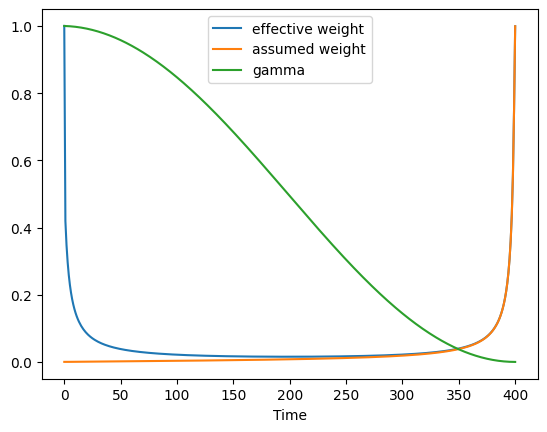

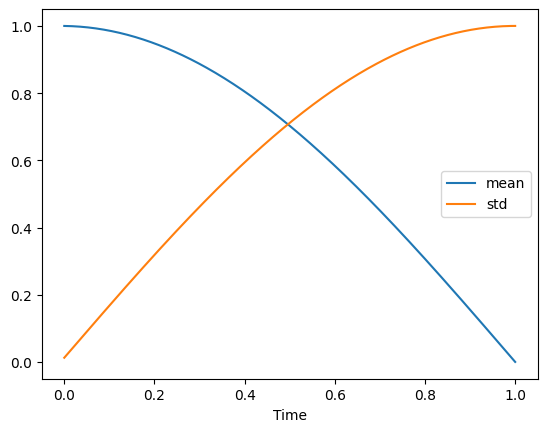

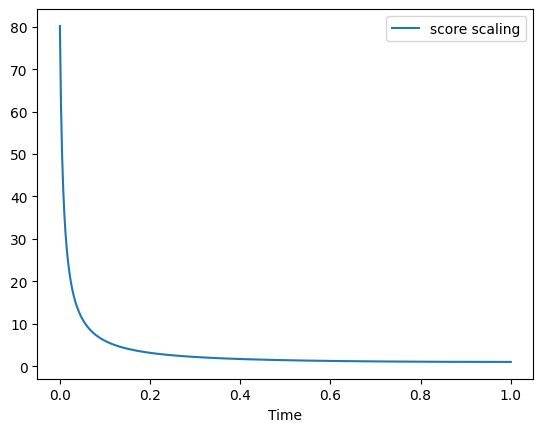

In [38]:
T = 400
time, gamma, delta_t = generate_diffusion_time(T, 400)

plt.plot(time, delta_t / (1-gamma), label='effective weight')
plt.plot(time, delta_t, label='assumed weight')
plt.plot(time, gamma, label='gamma')
#plt.plot(time / T, -1 / torch.sqrt(1 - gamma) * delta_t, label='sampling step')
plt.xlabel('Time')
plt.legend()
plt.show()

plt.plot(time / T, torch.sqrt(gamma), label='mean')
plt.plot(time / T, torch.sqrt(1 - gamma), label='std')
plt.xlabel('Time')
plt.legend()
plt.show()

plt.plot(time / T, 1 / torch.sqrt(1- gamma), label='score scaling')
plt.xlabel('Time')
plt.legend()
plt.show()

In [39]:
delta_t

tensor([1.5545e-04, 1.1230e-04, 1.4257e-04, 1.7315e-04, 2.0337e-04, 2.3377e-04,
        2.6417e-04, 2.9451e-04, 3.2496e-04, 3.5542e-04, 3.8570e-04, 4.1616e-04,
        4.4656e-04, 4.7702e-04, 5.0765e-04, 5.3787e-04, 5.6845e-04, 5.9903e-04,
        6.2948e-04, 6.6006e-04, 6.9058e-04, 7.2122e-04, 7.5185e-04, 7.8243e-04,
        8.1313e-04, 8.4364e-04, 8.7446e-04, 9.0522e-04, 9.3597e-04, 9.6661e-04,
        9.9748e-04, 1.0284e-03, 1.0592e-03, 1.0901e-03, 1.1210e-03, 1.1520e-03,
        1.1830e-03, 1.2141e-03, 1.2451e-03, 1.2763e-03, 1.3074e-03, 1.3386e-03,
        1.3698e-03, 1.4010e-03, 1.4324e-03, 1.4637e-03, 1.4952e-03, 1.5265e-03,
        1.5581e-03, 1.5897e-03, 1.6212e-03, 1.6530e-03, 1.6845e-03, 1.7163e-03,
        1.7482e-03, 1.7800e-03, 1.8119e-03, 1.8438e-03, 1.8760e-03, 1.9079e-03,
        1.9401e-03, 1.9724e-03, 2.0045e-03, 2.0370e-03, 2.0695e-03, 2.1017e-03,
        2.1344e-03, 2.1669e-03, 2.1996e-03, 2.2324e-03, 2.2652e-03, 2.2980e-03,
        2.3310e-03, 2.3642e-03, 2.3972e-

In [10]:
delta_t / (1-gamma)

tensor([1.0000, 0.4194, 0.3475, 0.2968, 0.2585, 0.2291, 0.2057, 0.1866, 0.1708,
        0.1574, 0.1460, 0.1361, 0.1275, 0.1199, 0.1132, 0.1072, 0.1018, 0.0969,
        0.0925, 0.0885, 0.0848, 0.0814, 0.0783, 0.0754, 0.0727, 0.0702, 0.0679,
        0.0657, 0.0637, 0.0617, 0.0600, 0.0583, 0.0567, 0.0552, 0.0538, 0.0524,
        0.0511, 0.0499, 0.0487, 0.0476, 0.0466, 0.0456, 0.0446, 0.0437, 0.0428,
        0.0420, 0.0412, 0.0404, 0.0397, 0.0390, 0.0383, 0.0376, 0.0370, 0.0364,
        0.0358, 0.0352, 0.0347, 0.0341, 0.0336, 0.0331, 0.0327, 0.0322, 0.0317,
        0.0313, 0.0309, 0.0305, 0.0301, 0.0297, 0.0293, 0.0290, 0.0286, 0.0283,
        0.0279, 0.0276, 0.0273, 0.0270, 0.0267, 0.0264, 0.0261, 0.0259, 0.0256,
        0.0253, 0.0251, 0.0249, 0.0246, 0.0244, 0.0242, 0.0239, 0.0237, 0.0235,
        0.0233, 0.0231, 0.0229, 0.0227, 0.0225, 0.0223, 0.0222, 0.0220, 0.0218,
        0.0216, 0.0215, 0.0213, 0.0212, 0.0210, 0.0209, 0.0207, 0.0206, 0.0204,
        0.0203, 0.0202, 0.0200, 0.0199, 

In [11]:
 # Loss function for weighted MSE
def weighted_mse_loss(inputs, targets, weights):
    return torch.mean(weights * torch.sum((inputs - targets)**2, dim=-1))


def compute_score_loss(x_batch, theta_prime_batch, model, diffusion_time, gamma, delta_t, device=None):
    # sample a diffusion time for each sample in the batch
    t_index = torch.randint(0, len(diffusion_time), size=(x_batch.shape[0],), device=device)
    t = diffusion_time[t_index]
    g = gamma[t_index]
    w = delta_t[t_index]
    # sample from the Gaussian kernel, just learn the noise
    epsilon = torch.randn_like(theta_prime_batch, dtype=torch.float32, device=device)
    theta_batch = torch.sqrt(g) * theta_prime_batch + torch.sqrt(1 - g) * epsilon
    # calculate the score for the sampled theta
    score_pred = model(theta=theta_batch, t=t, x=x_batch)
    # calculate the loss
    loss = weighted_mse_loss(score_pred, epsilon, weights=w / (1 - g))
    return loss


# Training loop for Score Model
def train_score_model(model, dataloader, dataloader_valid=None,
                      T=400, epochs=100, lr=1e-3, steps_diffusion_time=400, device=None):
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    # Add Cosine Annealing Scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

    # Generate diffusion time and step size
    diffusion_time, gamma, delta_t = generate_diffusion_time(max_t=T, steps=steps_diffusion_time, device=device)

    # Add a new dimension so that each tensor has shape (steps, 1)
    diffusion_time = diffusion_time.unsqueeze(1)
    gamma = gamma.unsqueeze(1)
    delta_t = delta_t.unsqueeze(1)

    # Training loop
    loss_history = np.zeros((epochs, 2))
    for epoch in range(epochs):
        total_loss = []
        model.train()
        # for each sample in the batch, calculate the loss for a random diffusion time
        for theta_global_prime_batch, theta_local_prime_batch, x_batch in dataloader:
            # initialize the gradients
            optimizer.zero_grad()
            theta_prime_batch = torch.concat([theta_global_prime_batch, theta_local_prime_batch], dim=-1)
            # calculate the loss
            loss = compute_score_loss(x_batch=x_batch, theta_prime_batch=theta_prime_batch,
                                      model=model, diffusion_time=diffusion_time, gamma=gamma, delta_t=delta_t, device=device)
            loss.backward()
            # gradient clipping
            nn.utils.clip_grad_norm_(model.parameters(), 3.0)
            optimizer.step()
            total_loss.append(loss.item())

        scheduler.step()

        # validate the model
        model.eval()
        valid_loss = []
        if dataloader_valid is not None:
            for theta_global_prime_batch, theta_local_prime_batch, x_batch in dataloader_valid:
                with torch.no_grad():
                    theta_prime_batch = torch.concat([theta_global_prime_batch, theta_local_prime_batch], dim=-1)
                    loss = compute_score_loss(x_batch, theta_prime_batch=theta_prime_batch,
                                              model=model, diffusion_time=diffusion_time, gamma=gamma, delta_t=delta_t, device=device)
                    valid_loss.append(loss.item())

        loss_history[epoch] = [np.median(total_loss), np.median(valid_loss)]
        print(f"Epoch {epoch+1}/{epochs}, Loss: {np.median(total_loss):.4f}, "
              f"Valid Loss: {np.median(valid_loss):.4f}", end='\r')
    return loss_history

In [12]:
# Hyperparameters
n_samples = 10000
batch_size = 128
T = 400
steps_time = T

score_model = HierarchicalScoreModel(
    input_dim_theta_global=n_params_global,
    input_dim_theta_local=n_params_local,
    input_dim_x=1,
    hidden_dim=64,
)
score_model.to(torch_device)

# Create model and dataset
thetas_global, thetas_local, xs = generate_synthetic_data(n_samples, device=torch_device)
# Normalize data
thetas_global = (thetas_global - prior.prior_global_mean) / prior.prior_global_std
thetas_local = (thetas_local - prior.prior_local_mean) / prior.prior_local_std
xs = (xs - prior.x_mean) / prior.x_std

# Create dataloader
dataset = TensorDataset(thetas_global, thetas_local, xs)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# create validation data
valid_prior_global, valid_prior_local, valid_data = generate_synthetic_data(batch_size*2, device=torch_device)
valid_data = (valid_data - prior.x_mean) / prior.x_std
valid_prior_global = (valid_prior_global - prior.prior_global_mean) / prior.prior_global_std
valid_prior_local = (valid_prior_local - prior.prior_local_mean) / prior.prior_local_std
dataset_valid = TensorDataset(valid_prior_global, valid_prior_local, valid_data)
dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size)

In [13]:
# Train model
loss_history = train_score_model(score_model, dataloader, dataloader_valid=dataloader_valid,
                                 T=T, epochs=100, lr=1e-3, steps_diffusion_time=steps_time,
                                 device=torch_device)


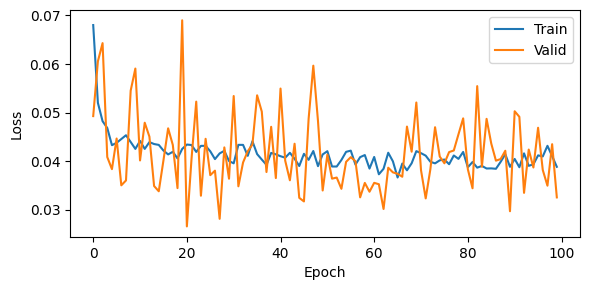

In [14]:
# plot loss history
plt.figure(figsize=(6, 3), tight_layout=True)
plt.plot(loss_history[:, 0], label='Train')
plt.plot(loss_history[:, 1], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
# check the error prediction: is it close to the noise?
loss_list_error = {}
loss_list_score = {}
loss_list_score_w = {}
with torch.no_grad():
    # Generate diffusion time and step size
    diffusion_time, gamma, beta_t = generate_diffusion_time(max_t=T, steps=steps_time, device=torch_device)
    for t_index in range(len(diffusion_time)):
        t = diffusion_time[t_index]
        g = gamma[t_index]
        w = delta_t[t_index]

        for theta_global_batch, theta_local_batch, x_batch in dataloader_valid:
            theta_batch = torch.cat([theta_global_batch, theta_local_batch], dim=-1)
            theta_batch = theta_batch.to(torch_device)

            # sample from the Gaussian kernel, just learn the noise
            epsilon = torch.randn_like(theta_batch, dtype=torch.float32, device=torch_device)


            # perturb the theta batch
            t_tensor = torch.full((theta_batch.shape[0], 1), t, dtype=torch.float32, device=torch_device)
            mean = torch.sqrt(g) * theta_batch
            std = torch.sqrt(1 - g)
            theta_batch_perturbed = mean + std * epsilon

            # calculate the score for the perturbed theta
            error_pred = score_model(theta=theta_batch_perturbed, t=t_tensor, x=x_batch)

            # calculate the loss (sum over the last dimension, mean over the batch)
            loss = torch.mean(torch.sum((error_pred - epsilon)**2, dim=-1))
            loss_list_error[t.item()] = loss.item()

            # calculate the score for the perturbed theta
            score_pred = -error_pred / std
            pred = score_function(x_t=theta_batch_perturbed, x0=theta_batch, t=t_tensor, max_t=T)

            loss = torch.mean(torch.sum((score_pred - pred)**2, dim=-1))
            loss_list_score[t.item()] = loss.item()

            # calculate the weighted loss
            loss = torch.mean(w * torch.sum((score_pred - pred)**2, dim=-1))
            loss_list_score_w[t.item()] = loss.item()

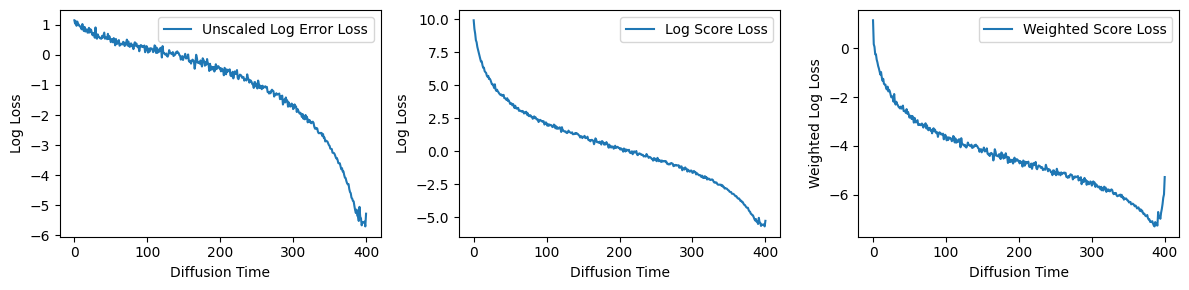

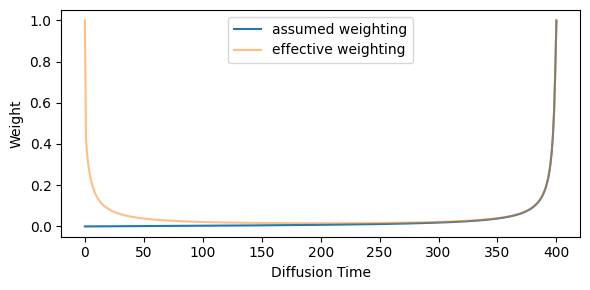

In [34]:
import pandas as pd
df_error = pd.DataFrame(loss_list_error.items(), columns=['Time', 'Loss'])
df_score = pd.DataFrame(loss_list_score.items(), columns=['Time', 'Loss'])
df_score_w = pd.DataFrame(loss_list_score_w.items(), columns=['Time', 'Loss'])

fig, ax = plt.subplots(ncols=3, sharex=True, figsize=(12, 3), tight_layout=True)
ax[0].plot(df_error['Time'], np.log(df_error['Loss']), label='Unscaled Log Error Loss')  # error and score should be the same, when error weighted by 1 / std(t)**2
ax[1].plot(df_score['Time'], np.log(df_score['Loss']), label='Log Score Loss')
ax[2].plot(df_score_w['Time'], np.log(df_score_w['Loss']), label='Weighted Score Loss')
for a in ax:
    a.set_xlabel('Diffusion Time')
    a.set_ylabel('Log Loss')
    a.legend()
ax[-1].set_ylabel('Weighted Log Loss')
plt.show()

plt.figure(figsize=(6, 3), tight_layout=True)
plt.plot(diffusion_time, delta_t, label='assumed weighting')
plt.plot(diffusion_time, delta_t / (1 - gamma), label='effective weighting', alpha=0.5)
plt.xlabel('Diffusion Time')
plt.ylabel('Weight')
plt.legend()
plt.show()

# Sampling

In [27]:
# Annealed Langevin Dynamics for Sampling
def langevin_sampling(model, x_obs, n_post_samples, conditions=None, steps=5, device=None):
    x_obs_norm = (x_obs - prior.x_mean) / prior.x_std  # assumes x_obs is not standardized
    x_obs_norm = x_obs_norm.reshape(x_obs_norm.shape[0], -1)
    n_obs = x_obs_norm.shape[-1]
    n_time_steps = x_obs_norm.shape[0]
    x_obs_norm = x_obs_norm.T[:, :, np.newaxis]

    # Ensure x_obs_norm is a PyTorch tensor
    if not isinstance(x_obs_norm, torch.Tensor):
        x_obs_norm = torch.tensor(x_obs_norm, dtype=torch.float32, device=device)

    # Initialize parameters
    if conditions is None:  # global
        n_params = n_params_global
        theta = torch.randn(n_post_samples, n_params_global, dtype=torch.float32, device=device) / torch.sqrt(torch.tensor(n_obs, dtype=torch.float32, device=device))
        conditions_exp = None
    else:
        # Ensure conditions is a PyTorch tensor
        if not isinstance(conditions, torch.Tensor):
            conditions = torch.tensor(conditions, dtype=torch.float32, device=device)

        n_params = n_params_local*n_obs
        theta = torch.randn(n_post_samples, n_obs, n_params_local, dtype=torch.float32, device=device)
        conditions = (conditions - prior.prior_global_mean) / prior.prior_global_std
        conditions_exp = conditions.unsqueeze(0).expand(n_post_samples, n_obs, -1).reshape(-1, n_params_global)

    # Generate diffusion time parameters
    diffusion_time, gamma, delta_t = generate_diffusion_time(max_t=T, steps=steps_time, device=device)
    scaling = -1 / torch.sqrt(1 - gamma)

    # Expand x_obs_norm to match the number of posterior samples
    x_exp = x_obs_norm.unsqueeze(0).expand(n_post_samples, n_obs, n_time_steps, -1)  # Shape: (n_post_samples, n_obs, n_time_steps, d)
    x_expanded = x_exp.reshape(n_post_samples*n_obs, n_time_steps, -1)

    # Reverse iterate over diffusion times and step sizes
    with torch.no_grad():
        for step_size, t, scale in tqdm(zip(delta_t.flip(0), diffusion_time.flip(0), scaling.flip(0)), total=steps_time+1):
            # Create tensor for current time step
            t_tensor = torch.full((n_post_samples, 1), t, dtype=torch.float32, device=device)
            t_exp = t_tensor.unsqueeze(1).expand(-1, n_obs, -1).reshape(-1, 1)

            for _ in range(steps):
                # Sample Gaussian noise
                eps = torch.randn_like(theta, dtype=torch.float32, device=device)

                if conditions is None:
                    # Compute prior score
                    prior_score = prior.score_global_batch(theta)
                else:
                    prior_score = 0

                # Compute model scores
                if conditions is None:
                    theta_exp = theta.unsqueeze(1).expand(-1, n_obs, -1).reshape(-1, n_params_global)
                    model_scores = model.forward_global(theta_global=theta_exp, t=t_exp, x=x_expanded)
                    # Sum over observations
                    model_scores = model_scores.reshape(n_post_samples, n_obs, -1).sum(dim=1)
                else:
                    theta_exp = theta.reshape(-1, n_params_local)
                    model_scores = model.forward_local(theta_local=theta_exp, t=t_exp, x=x_expanded, theta_global=conditions_exp)
                    model_scores = model_scores.reshape(n_post_samples, n_obs, -1)

                # Compute updated scores and perform Langevin step
                # scaling since we learned the scaled score network (noise)
                model_scores = scale * model_scores
                scores = (1 - n_obs) * (T - t) / T * prior_score + model_scores
                theta = theta + (step_size / 2) * scores + torch.sqrt(step_size) * eps
            if torch.isnan(theta).any():
                print("NaNs in theta")
                break
    # correct for normalization
    if conditions is None:
        theta = theta * prior.prior_global_std + prior.prior_global_mean
    else:
        theta = theta * prior.prior_local_std + prior.prior_local_mean
    # convert to numpy
    theta = theta.detach().numpy().reshape(n_post_samples, n_params)
    return theta

# Validation

In [31]:
n_grid = 8
valid_prior_global, valid_prior_local, valid_data = generate_synthetic_data(10, n_grid=n_grid, full_grid=True, device=torch_device)
n_post_samples = 20

In [32]:
posterior_global_samples_valid = np.array([langevin_sampling(score_model, vd, n_post_samples=n_post_samples, steps=1,
                                                          device=torch_device)
                                        for vd in valid_data])

100%|██████████| 401/401 [00:02<00:00, 159.24it/s]


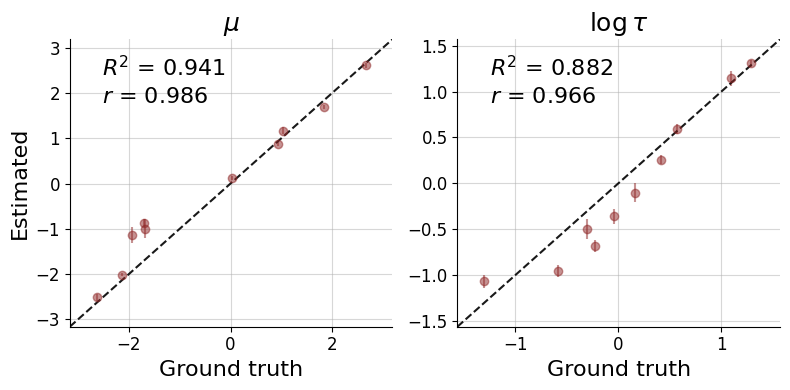

In [33]:
diagnostics.plot_recovery(posterior_global_samples_valid, np.array(valid_prior_global), param_names=[r'$\mu$', r'$\log \tau$']);

In [ ]:
diagnostics.plot_sbc_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, param_names=[r'$\mu$', r'$\log \tau$']);

In [ ]:
conditions_global = np.median(posterior_global_samples_valid, axis=0)
posterior_local_samples_valid = np.array([langevin_sampling(score_model, vd, n_post_samples=n_post_samples, conditions=c, steps=1,
                                                          device=torch_device)
                                        for vd, c in zip(valid_data, conditions_global)])

In [ ]:
diagnostics.plot_recovery(posterior_local_samples_valid.reshape(valid_data.shape[0], n_post_samples, -1),
                          np.array(valid_prior_local).reshape(valid_data.shape[0], -1),
                          param_names=['$\\theta_{'+str(i)+'}$' for i in range(n_grid**2)]);

In [ ]:
diagnostics.plot_sbc_ecdf(posterior_local_samples_valid.reshape(valid_data.shape[0], n_post_samples, -1),
                          np.array(valid_prior_local).reshape(valid_data.shape[0], -1),
                          difference=True, stacked=True,
                          param_names=['$\\theta_{'+str(i)+'}$' for i in range(n_grid**2)]);

In [ ]:
valid_id = 1
print('Data')
visualize_simulation_output(valid_data[valid_id])
print('Global Estimates')
print('mu:', np.median(posterior_global_samples_valid[valid_id, :, 0]), np.std(posterior_global_samples_valid[valid_id, :, 0]))
print('log tau:', np.median(posterior_global_samples_valid[valid_id, :, 1]), np.std(posterior_global_samples_valid[valid_id, :, 1]))
print('True')
print('mu:', valid_prior_global[valid_id][0].item())
print('log tau:', valid_prior_global[valid_id][1].item())

In [ ]:
med = np.median(posterior_local_samples_valid[valid_id].reshape(n_post_samples, n_grid, n_grid), axis=0)
std = np.std(posterior_local_samples_valid[valid_id].reshape(n_post_samples, n_grid, n_grid), axis=0)
error = (med-valid_prior_local[valid_id].numpy())**2
visualize_simulation_output(np.stack((med, valid_prior_local[valid_id], )),
                            title_prefix=['Posterior Median', 'True'])

visualize_simulation_output(np.stack((std, error)), title_prefix=['Uncertainty', 'Error'], same_scale=False)